DATA VERIFICATION REPORT

1. TABLE SIZES:
   Listings: 625 records
   Users: 1872 records
   Searches: 26532 records
   Bookings: 9110 records

2. DATA TYPES CHECK:

Listings columns:
venue_id            int64
host_id             int64
metro_area         object
venue_type         object
price_per_hour    float64
capacity            int64
created_date       object
listing_title      object
is_active           int64
dtype: object

3. NULL VALUES CHECK:
listings: No null values ✓
users: No null values ✓
searches: No null values ✓
bookings: No null values ✓

4. DATE RANGES:
Searches: 2024-01-01 to 2024-12-31
Bookings: 2024-01-02 to 2025-01-03
Events: 2024-01-02 to 2025-01-29

5. LIQUIDITY INDICATORS BY METRO:

San Francisco:
  Supply (listings): 190
  Demand (searches): 4406
  Bookings: 1654
  Conversion rate: 37.5%
  Avg bookings per venue: 8.71

Los Angeles:
  Supply (listings): 155
  Demand (searches): 4147
  Bookings: 1606
  Conversion rate: 38.7%
  Avg bookings per venue: 10.36

New Y

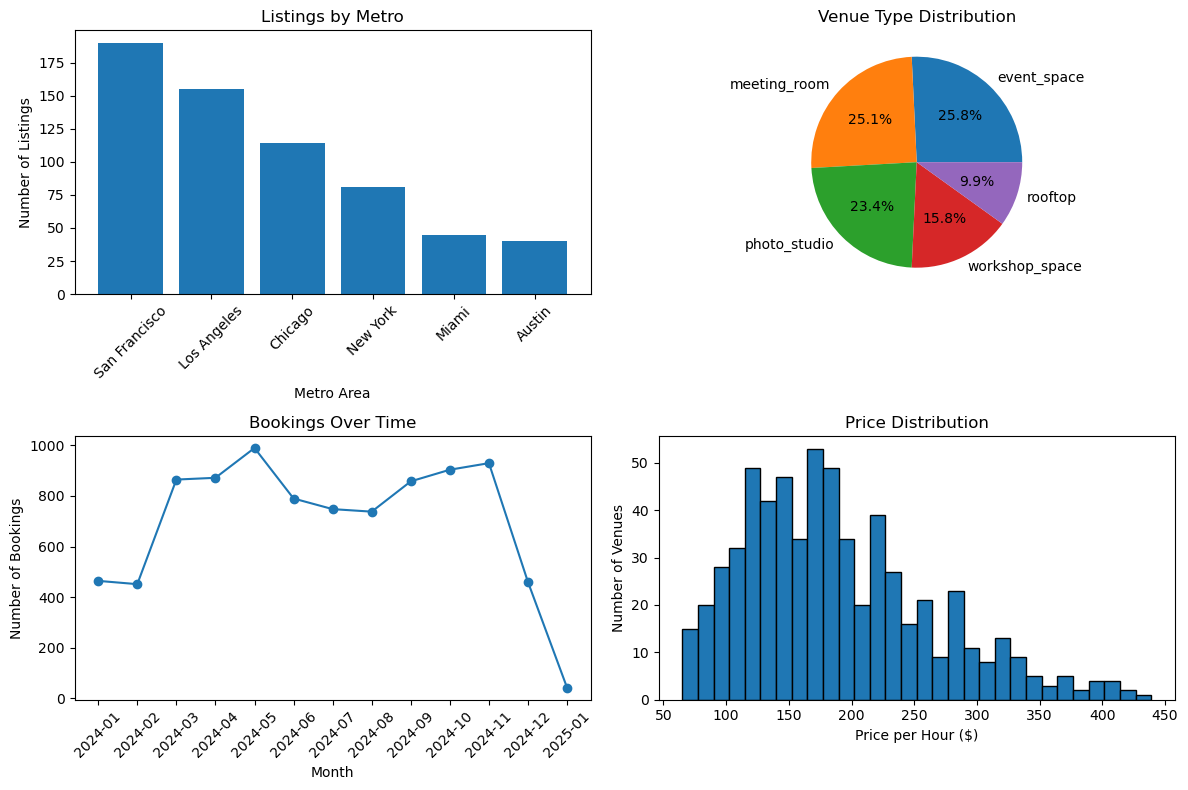


7. SAMPLE DATA PREVIEW:

First 3 listings:
   venue_id  host_id     metro_area      venue_type  price_per_hour  capacity  \
0         1        1  San Francisco    meeting_room           172.0         8   
1         2        1  San Francisco  workshop_space           135.0        33   
2         3        1  San Francisco    photo_studio           280.0        23   

  created_date                    listing_title  is_active  
0   2024-08-11    Meeting Room in San Francisco          1  
1   2024-12-01  Workshop Space in San Francisco          0  
2   2023-01-13    Photo Studio in San Francisco          1  

First 3 bookings:
   booking_id  venue_id  guest_id  search_id booking_date event_date  \
0           1        24      1838          1   2024-01-02 2024-01-29   
1           2       588       657          5   2024-01-04 2024-01-14   
2           3       102      1395          6   2024-01-04 2024-01-16   

   hours_booked  total_amount     status booking_month  
0             6       

In [1]:
# Data Verification Notebook
# Run this after generating the data to ensure everything worked correctly

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to database
conn = sqlite3.connect('../data/peerspace_marketplace.db')

# Load all tables
listings_df = pd.read_sql("SELECT * FROM listings", conn)
users_df = pd.read_sql("SELECT * FROM users", conn)
searches_df = pd.read_sql("SELECT * FROM searches", conn)
bookings_df = pd.read_sql("SELECT * FROM bookings", conn)

print("=" * 50)
print("DATA VERIFICATION REPORT")
print("=" * 50)

# 1. Check table sizes
print("\n1. TABLE SIZES:")
print(f"   Listings: {len(listings_df)} records")
print(f"   Users: {len(users_df)} records")
print(f"   Searches: {len(searches_df)} records")
print(f"   Bookings: {len(bookings_df)} records")

# 2. Check data types
print("\n2. DATA TYPES CHECK:")
print("\nListings columns:")
print(listings_df.dtypes)

# 3. Check for nulls
print("\n3. NULL VALUES CHECK:")
for df_name, df in [('listings', listings_df), ('users', users_df), 
                     ('searches', searches_df), ('bookings', bookings_df)]:
    null_counts = df.isnull().sum()
    if null_counts.any():
        print(f"\n{df_name} has nulls in:")
        print(null_counts[null_counts > 0])
    else:
        print(f"{df_name}: No null values ✓")

# 4. Check date ranges
print("\n4. DATE RANGES:")
# Convert date strings to datetime
searches_df['search_date'] = pd.to_datetime(searches_df['search_date'])
bookings_df['booking_date'] = pd.to_datetime(bookings_df['booking_date'])
bookings_df['event_date'] = pd.to_datetime(bookings_df['event_date'])
listings_df['created_date'] = pd.to_datetime(listings_df['created_date'])

print(f"Searches: {searches_df['search_date'].min().date()} to {searches_df['search_date'].max().date()}")
print(f"Bookings: {bookings_df['booking_date'].min().date()} to {bookings_df['booking_date'].max().date()}")
print(f"Events: {bookings_df['event_date'].min().date()} to {bookings_df['event_date'].max().date()}")

# 5. Check liquidity indicators
print("\n5. LIQUIDITY INDICATORS BY METRO:")
for metro in listings_df['metro_area'].unique():
    metro_listings = listings_df[listings_df['metro_area'] == metro]
    metro_searches = searches_df[searches_df['metro_area'] == metro]
    metro_bookings = bookings_df[bookings_df['venue_id'].isin(metro_listings['venue_id'])]
    
    if len(metro_searches) > 0:
        conversion_rate = len(metro_bookings) / len(metro_searches) * 100
        avg_utilization = len(metro_bookings) / len(metro_listings) if len(metro_listings) > 0 else 0
        
        print(f"\n{metro}:")
        print(f"  Supply (listings): {len(metro_listings)}")
        print(f"  Demand (searches): {len(metro_searches)}")
        print(f"  Bookings: {len(metro_bookings)}")
        print(f"  Conversion rate: {conversion_rate:.1f}%")
        print(f"  Avg bookings per venue: {avg_utilization:.2f}")

# 6. Quick visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Listings by metro
metro_counts = listings_df['metro_area'].value_counts()
axes[0, 0].bar(metro_counts.index, metro_counts.values)
axes[0, 0].set_title('Listings by Metro')
axes[0, 0].set_xlabel('Metro Area')
axes[0, 0].set_ylabel('Number of Listings')
axes[0, 0].tick_params(axis='x', rotation=45)

# Venue type distribution
venue_counts = listings_df['venue_type'].value_counts()
axes[0, 1].pie(venue_counts.values, labels=venue_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Venue Type Distribution')

# Bookings over time
bookings_df['booking_month'] = bookings_df['booking_date'].dt.to_period('M')
monthly_bookings = bookings_df.groupby('booking_month').size()
axes[1, 0].plot(monthly_bookings.index.astype(str), monthly_bookings.values, marker='o')
axes[1, 0].set_title('Bookings Over Time')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Bookings')
axes[1, 0].tick_params(axis='x', rotation=45)

# Price distribution
axes[1, 1].hist(listings_df['price_per_hour'], bins=30, edgecolor='black')
axes[1, 1].set_title('Price Distribution')
axes[1, 1].set_xlabel('Price per Hour ($)')
axes[1, 1].set_ylabel('Number of Venues')

plt.tight_layout()
plt.savefig('../data/data_verification_plots.png', dpi=100, bbox_inches='tight')
plt.show()

# 7. Sample data preview
print("\n7. SAMPLE DATA PREVIEW:")
print("\nFirst 3 listings:")
print(listings_df.head(3))

print("\nFirst 3 bookings:")
print(bookings_df.head(3))

# 8. Check referential integrity
print("\n8. REFERENTIAL INTEGRITY CHECK:")
# Check if all bookings reference valid venues
invalid_venues = bookings_df[~bookings_df['venue_id'].isin(listings_df['venue_id'])]
if len(invalid_venues) > 0:
    print(f"❌ Found {len(invalid_venues)} bookings with invalid venue_ids")
else:
    print("✓ All bookings reference valid venues")

# Check if all bookings reference valid users
invalid_users = bookings_df[~bookings_df['guest_id'].isin(users_df['user_id'])]
if len(invalid_users) > 0:
    print(f"❌ Found {len(invalid_users)} bookings with invalid guest_ids")
else:
    print("✓ All bookings reference valid users")

print("\n" + "="*50)
print("✅ DATA VERIFICATION COMPLETE")
print("="*50)
print("\nYour synthetic dataset is ready for analysis!")
print("The data shows realistic marketplace dynamics with:")
print("- Varied liquidity levels across metros")
print("- Seasonal booking patterns")
print("- Different venue types and price points")
print("\nProceed to Step 2: SQL Analysis")

conn.close()